In [17]:
import pandas as pd
salaries = pd.read_csv("WAG_C_M.csv",";", index_col=["month"], parse_dates=["month"], dayfirst=True) #Загружаем данные
salaries.columns = ["Salary"]

Populating the interactive namespace from numpy and matplotlib


C:\Users\adm_user\Anaconda\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['product', 'pi']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


<Figure size 1440x720 with 0 Axes>

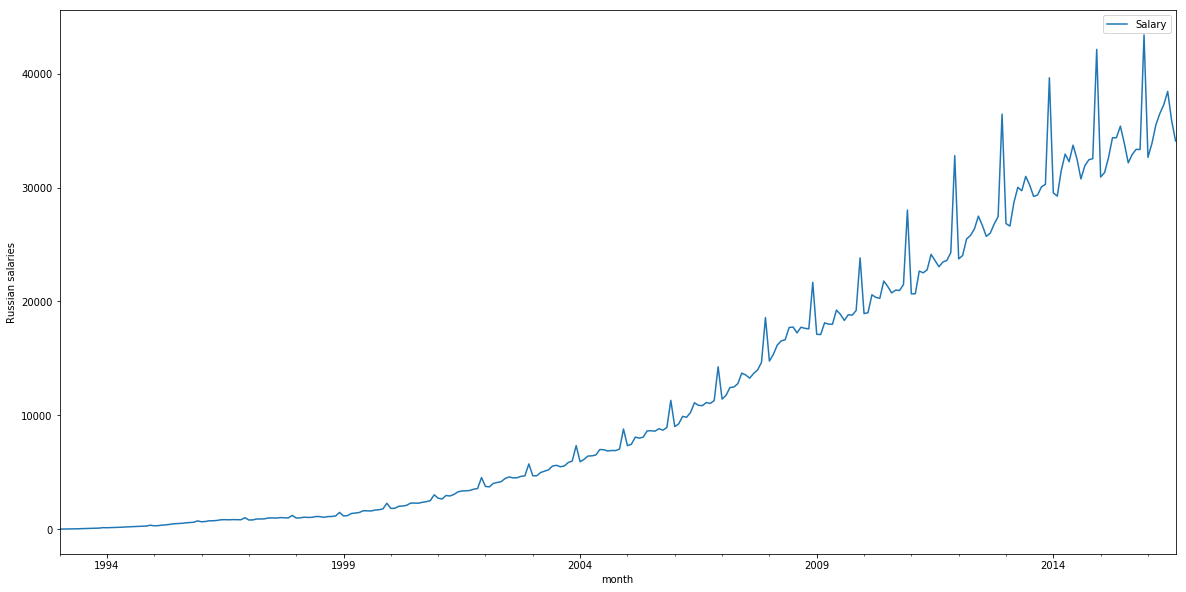

In [18]:
%pylab inline
pylab.figure(figsize(20,10))
salaries.plot()
pylab.ylabel("Russian salaries")
pylab.show()

Видим четко выраженный тренд и сезонность. Очевидно, что временной ряд не является стационарным. Дисперсия возрастает со временем. Строим STL и считаем критерий Дики-Фуллера.

Критерий Дики-Фуллера: p=0.9918


<Figure size 1080x720 with 0 Axes>

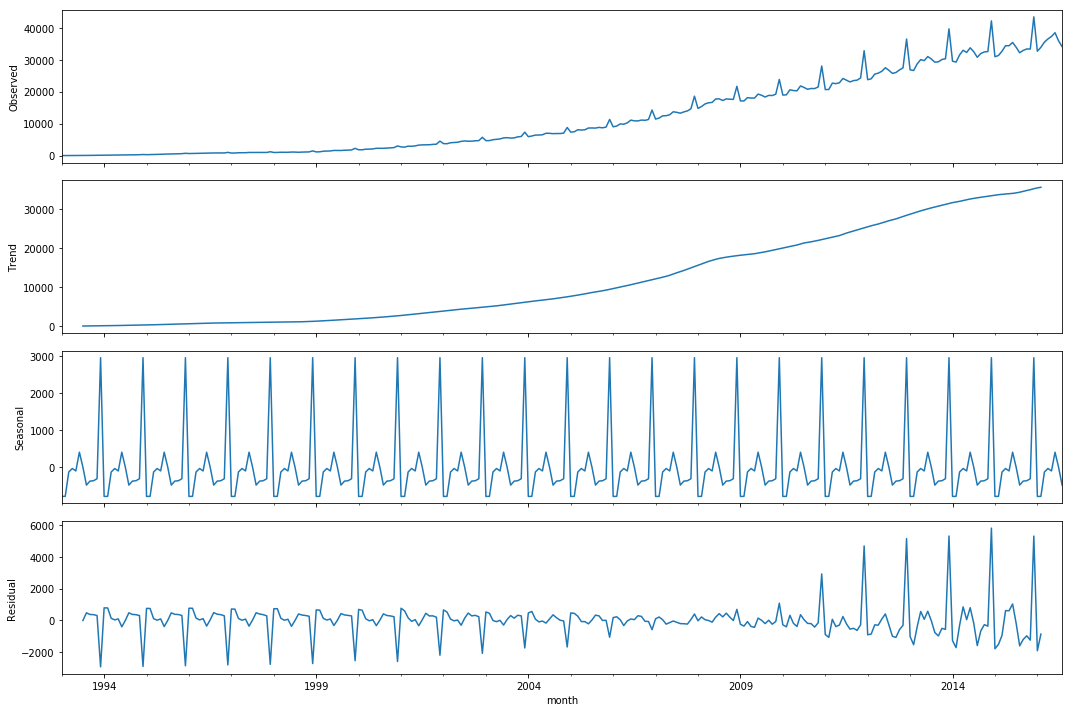

In [19]:
import statsmodels.api as sm 
def stl_decompose_pvalue(series):
    (adf,pvalue,usedlag,nobes,icbest,resstore) = sm.tsa.stattools.adfuller(series)
    print("Критерий Дики-Фуллера: p=%.4f" % pvalue)
    pylab.figure(figsize(15,10))
    sm.tsa.seasonal_decompose(series).plot()
    pylab.show()
stl_decompose_pvalue(salaries["Salary"])

Что мы видим: тренд + сезонность, дисперсия возрастает, ряд нестационарен.

### Попробуем решить проблему с дисперсией через преобразование Бокса-Кокса

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.6969


<Figure size 1080x720 with 0 Axes>

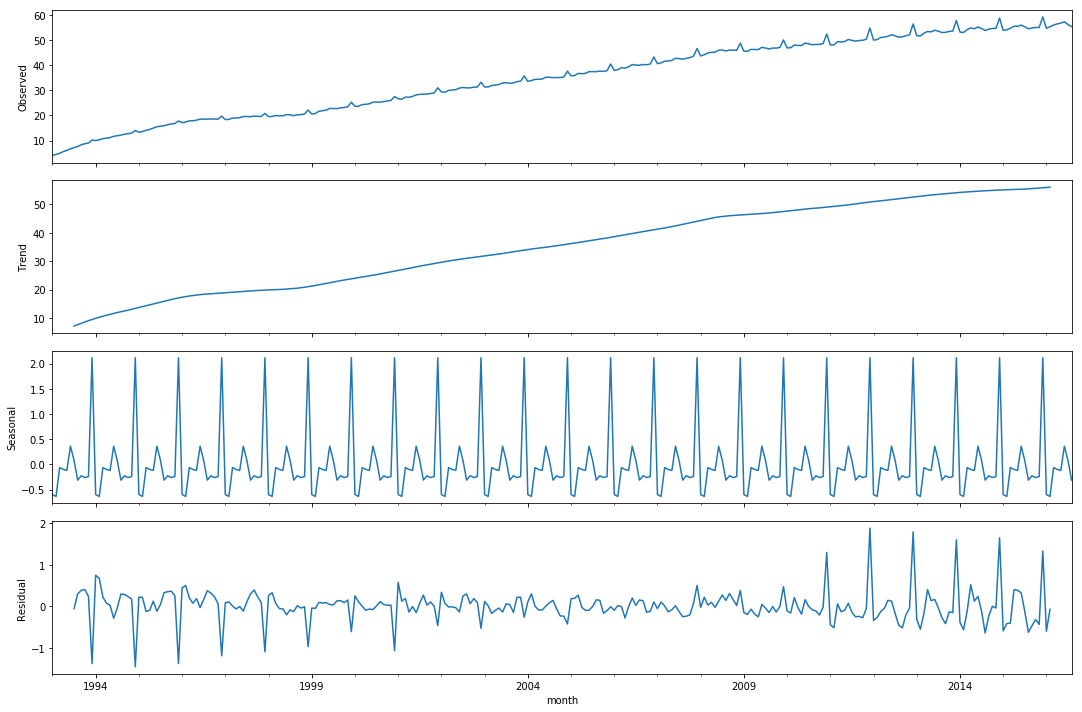

In [20]:
from scipy import stats
salaries["Salary_box"], lmbda = stats.boxcox(salaries["Salary"])
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
stl_decompose_pvalue(salaries["Salary_box"])

Дисперсия несколько стабилизировалась, но ряд остался нестационарным.

### Сделаем сезонное дифференцирование

Критерий Дики-Фуллера: p=0.0147


<Figure size 1080x720 with 0 Axes>

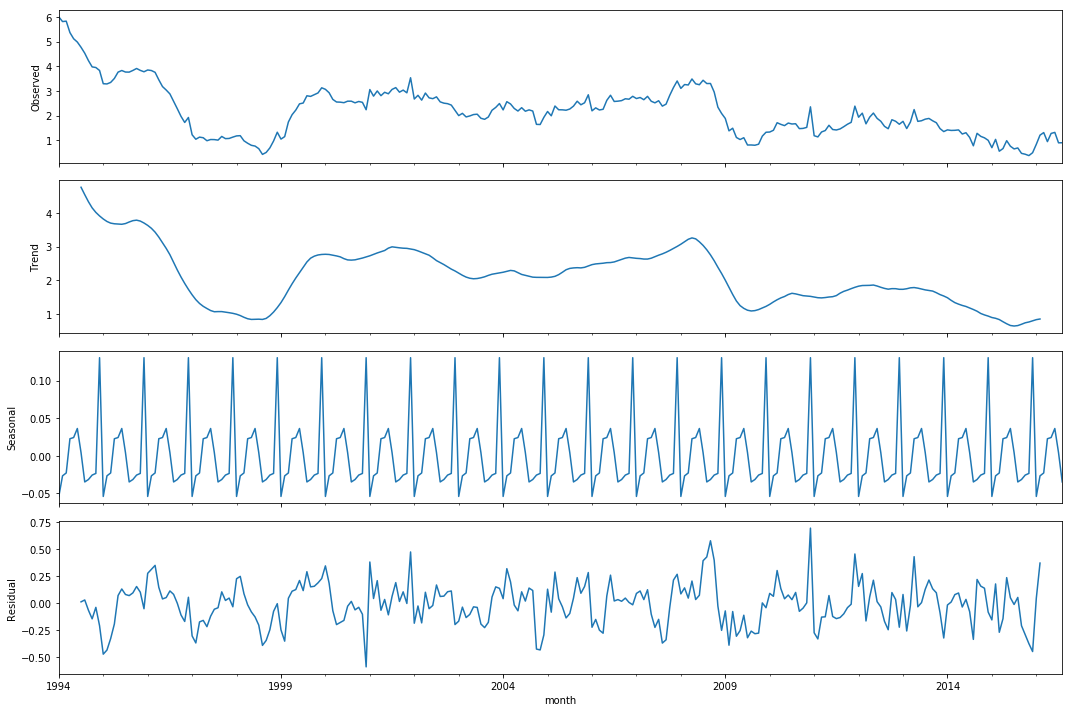

In [21]:
salaries["Salary_box_season"] = salaries["Salary_box"] - salaries["Salary_box"].shift(12)
stl_decompose_pvalue(salaries["Salary_box_season"].dropna())

Что мы видим? Критерий Дики-Фуллера на этот раз отвергает гипотезу нестационарности. Тренд сохранился. Прменим теперь обычное дифференцирование.

Критерий Дики-Фуллера: p=0.0000


<Figure size 1080x720 with 0 Axes>

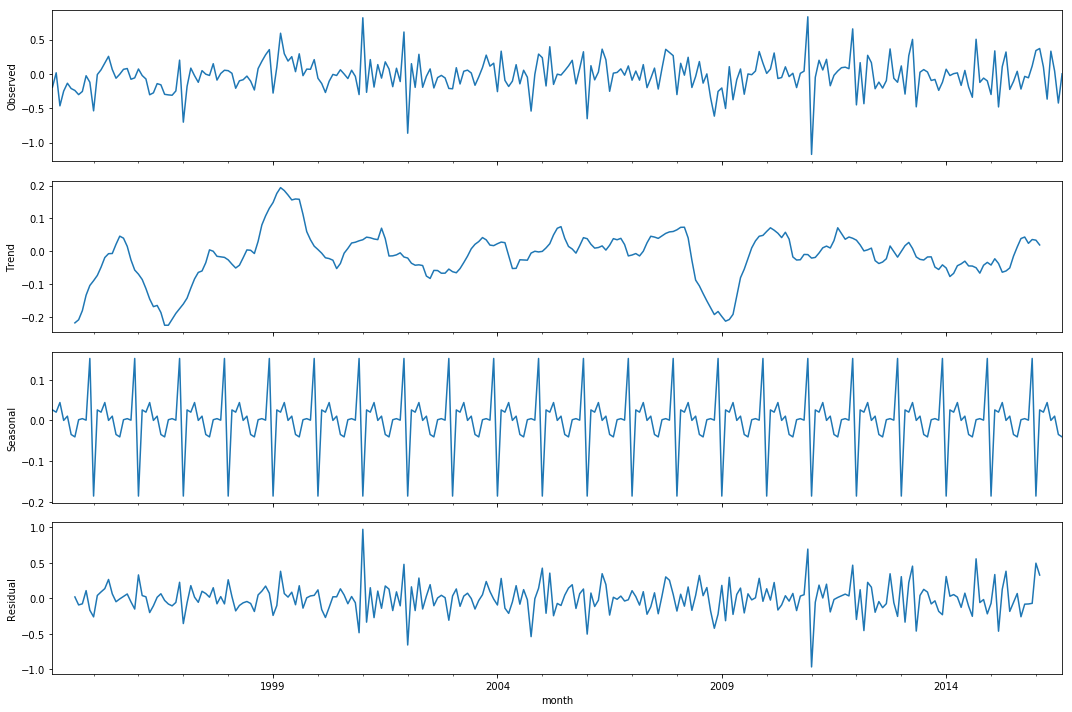

In [22]:
salaries["Salary_box_diff"] = salaries["Salary_box_season"] - salaries["Salary_box_season"].shift(1)
stl_decompose_pvalue(salaries["Salary_box_diff"].dropna())

И теперь исчез тренд. Ряд похож на стационарный плюс Критерий Дики-Фуллера снова отвергает гипотезу нестационарности.

### Посмотрим на автокорреляцию и частичную автокорреляцию

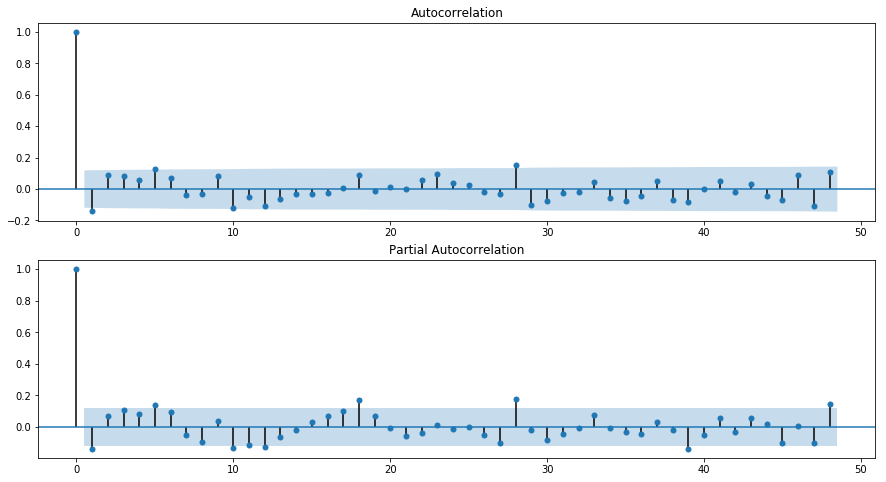

In [23]:
salaries_modified_values = salaries["Salary_box_diff"].dropna().values.squeeze()
pylab.figure(figsize(15,8))
ax = pylab.subplot(211)
sm.graphics.tsa.plot_acf(salaries_modified_values, lags=48, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(salaries_modified_values, lags=48, ax=ax)
pylab.show()

Необходимо подобрать параметры:
По автокорреляции Q = 0 (значимых сезонных лагов), q = 5 (видим три значимых несезонных лага 1, 5 и 28. 28 - слишком большое значение, поэтому выбираем 5).
По частичной автокорреляции: P = 4 (значимым является 48 лаг. Он сезонный, соответственно 48/12 = 4), p = 5 (выбираем между 1, 5, 18 и 28 лагами. Оптимально 5).

In [24]:
Qs = range(0, 1)
qs = range(0, 6)
Ps = range(0, 5)
ps = range(0, 6)
d=1
D=1
S=12

In [25]:
from itertools import product
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

180

Делаем полный перебор

In [28]:
%%time
import warnings
results = []
best_aic = float("inf")
warnings.filterwarnings("ignore")

for param in parameters_list:
    try:
        pi,qi,Pi,Qi = param
        model=sm.tsa.statespace.SARIMAX(
            salaries["Salary_box"],
            order=(pi, d, qi),
            seasonal_order=(Pi, D, Qi, S)).fit(disp=-1)
    except ValueError:
        print("wrong parameters:", param)
        continue
    aic = model.aic
    
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings("default")

Wall time: 36min 26s


Выбираем 5 лучших моделей

In [33]:
result_table = pd.DataFrame(results)
result_table.columns = ["parameters", "aic"]
print(result_table.sort_values(by = "aic", ascending=True).head())

       parameters        aic
176  (5, 5, 1, 0) -25.095274
146  (4, 5, 1, 0) -24.258289
177  (5, 5, 2, 0) -23.297167
147  (4, 5, 2, 0) -22.439680
175  (5, 5, 0, 0) -22.120541


И самую лучшую:

In [34]:
print best_model.summary()

                                 Statespace Model Results                                 
Dep. Variable:                         Salary_box   No. Observations:                  284
Model:             SARIMAX(5, 1, 5)x(1, 1, 0, 12)   Log Likelihood                  24.548
Date:                            Tue, 05 May 2020   AIC                            -25.095
Time:                                    17:50:08   BIC                             18.130
Sample:                                01-01-1993   HQIC                            -7.740
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2134      6.056     -0.035      0.972     -12.084      11.657
ar.L2          0.2367      4.368   

Посмотрим на остатки модели

Критерий Стьюдента: p = 0.625509
Критерий Дики-Фуллера: p = 0.000000


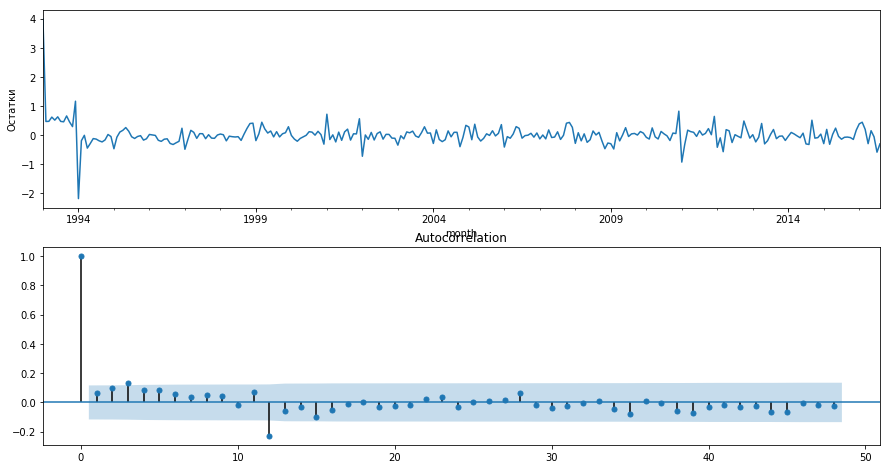

In [36]:
pylab.figure(figsize(15,8))
pylab.subplot(211)
best_model.resid.plot()
pylab.ylabel(u"Остатки")

ax = pylab.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid.values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p = %f" % stats.ttest_1samp(best_model.resid, 0)[1])
print("Критерий Дики-Фуллера: p = %f" % sm.tsa.stattools.adfuller(best_model.resid)[1])

Что можно сказать об остатках? Несмещены + стационарны. Что подтверждают наши критерии. Плюс остатки неавтокоррелированы.

Теперь посмотрим как наша лучшая модель описывает данные. Построим для этого 2 графика.

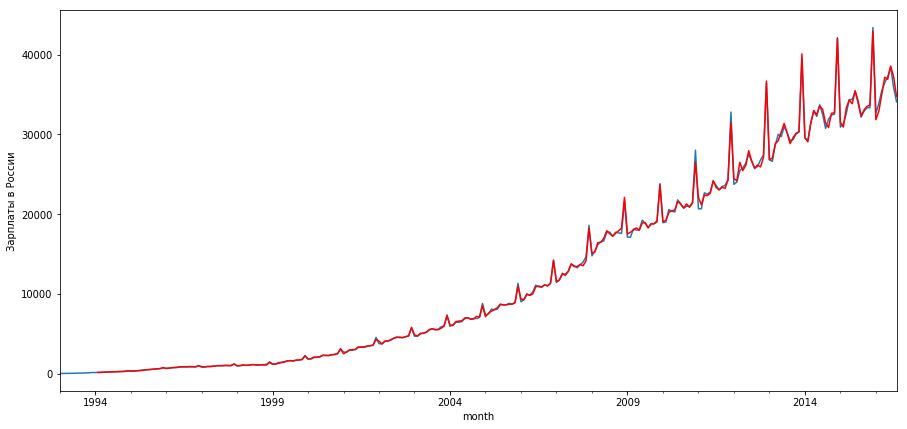

In [37]:
import numpy as np
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))
salaries_model = pd.DataFrame(
    invboxcox(best_model.fittedvalues, lmbda),
    salaries["Salary_box_diff"].dropna().index,
    ["Salary"])
pylab.figure(figsize(15,7))
salaries["Salary"].plot()
salaries_model["Salary"].plot(color='r')
pylab.ylabel(u"Зарплаты в России")
pylab.show()

2 графика практически совпадают, что говорит о высоком качестве модели. Сохранился даже тренд на увеличение дисперсии.

### Теперь строим прогноз:

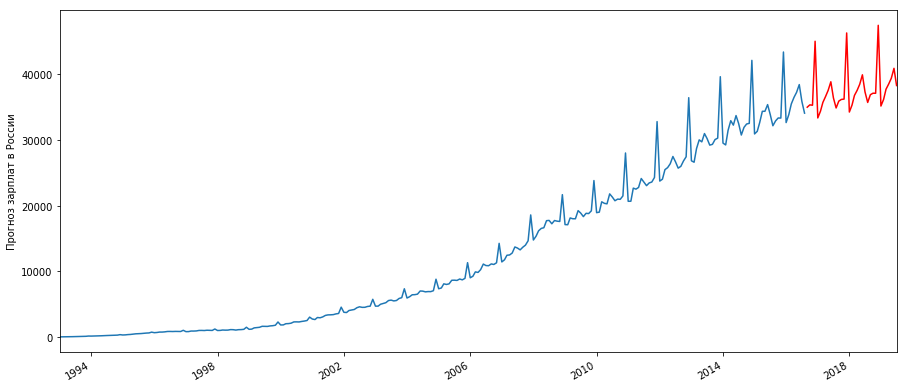

In [38]:
salaries_forecast = salaries[["Salary"]]
date_list = [datetime.datetime.strptime("2016-08-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns=salaries_forecast.columns)
salaries_forecast = pd.concat([salaries_forecast, future])
salaries_forecast["forecast"] = invboxcox(best_model.predict(start=284, end=284+36), lmbda)

pylab.figure(figsize(15,7))
salaries_forecast["Salary"].plot()
salaries_forecast["forecast"].plot(color='r')
pylab.ylabel(u"Прогноз зарплат в России")
pylab.show()

В полученном прогнозе сохранилось увеличение дисперсии со временем, тренд и сезонность. Прогноз выглядит довольно качественно. 